## import

In [2]:
from datetime import datetime
import time
import os
import pandas as pd
import numpy as np
import healpy as hp
import seaborn as sns
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from healpy.fitsfunc import read_map
import matplotlib.style as style
import camb
from camb import model, initialpower
from scipy.optimize import curve_fit

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
style.use('tableau-colorblind10')
colors = sns.color_palette("colorblind").as_hex()
#style.use('seaborn-colorblind')
today = datetime.today().strftime('%Y-%b-%d')

# Tableau Color Blind 10
tableau_colors = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau_colors)):  
    r, g, b = tableau_colors[i]  
    tableau_colors[i] = (r / 255., g / 255., b / 255.)

############### CMB colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
# this colormap directly with hp.mollview(m, cmap=colombi1_cmap)
cmap = colombi1_cmap

## extract CMB maps and masks

In [3]:
# Define some fixed params
NSIDE = 2048                                                                      # given in the name of the maps
APO = 5                                                                           # apodization length
HDU = 1
FREQ = 143 

gal_cover = 60                                                                    # % of cover in galacitc plane

GALCOVER_DICT = {
    'GAL020': 0,
    'GAL040': 1,
    'GAL060': 2,
    'GAL070': 3,
    'GAL080': 4,
    'GAL090': 5,
    'GAL097': 6,
    'GAL099': 7
}

FREQ_PS_DICT = {
    'F100': 0,
    'F143': 1,
    'F217': 2,
    'F353': 3,
    'F545': 4,
    'F857': 5,
} 

In [ ]:
# Define some fixed params
NSIDE = 2048                                                                      # given in the name of the maps
APO = 5                                                                           # apodization length
HDU = 1
FREQ = 143 

gal_cover = 60                                                                    # % of cover in galacitc plane

GALCOVER_DICT = {
    'GAL020': 0,
    'GAL040': 1,
    'GAL060': 2,
    'GAL070': 3,
    'GAL080': 4,
    'GAL090': 5,
    'GAL097': 6,
    'GAL099': 7
}

FREQ_PS_DICT = {
    'F100': 0,
    'F143': 1,
    'F217': 2,
    'F353': 3,
    'F545': 4,
    'F857': 5,
} 

def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    with fits.open(filepath) as hdul:
        hdul = fits.open(filepath)
        data = hdul[hdu].data                                              # hdul is a list of HDU objects
    
    return data

# define filepaths
filepath_hm1 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits'         # map for half mission 1 143 GHZ
filepath_hm2 = 'data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits'         # map for half mission 2 143 GHZ
filepath_gp = f'data/HFI_Mask_GalPlane-apo{APO}_2048_R2.00.fits'           # galactic plane mask for input apodization length
filepath_ps = 'data/HFI_Mask_PointSrc_2048_R2.00.fits'                     # mask point source
filepath_beamwin1 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm1.fits'           # beam transfer function for hm1
filepath_beamwin2 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm2.fits'           # beam transfer function for hm2
         
start1 = time.time()
print(f'Started Planck data extraction:')
print('='*80)
# extract data by using read_map funcitn from healpy
sky_hm1, sky_hm2 = read_map(filepath_hm1, field=0, hdu=HDU), read_map(filepath_hm2, field=0, hdu=HDU)

field_gp = GALCOVER_DICT[f'GAL0{gal_cover}']
mask_gp = read_map(filepath_gp, field=field_gp, hdu=HDU)

field_ps = FREQ_PS_DICT['F143']
mask_ps = read_map(filepath_ps, field=field_ps, hdu=HDU)

# use the extract_data function to find the beam window function
beam_hm1, beam_hm2 = extract_data(filepath_beamwin1), extract_data(filepath_beamwin2)

end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

In [ ]:
if False:
    # define filepaths
    filepath_hm1 = 'HFI_SkyMap_143_2048_R3.01_halfmission-1.fits'         # map for half mission 1 143 GHZ
    filepath_hm2 = 'HFI_SkyMap_143_2048_R3.01_halfmission-2.fits'         # map for half mission 2 143 GHZ
    filepath_gp = f'HFI_Mask_GalPlane-apo{APO}_2048_R2.00.fits'           # galactic plane mask for input apodization length
    filepath_ps = 'HFI_Mask_PointSrc_2048_R2.00.fits'                     # mask point source
    filepath_beamwin1 = 'Bl_T_R3.01_fullsky_143hm1x143hm1.fits'           # beam transfer function for hm1
    filepath_beamwin2 = 'Bl_T_R3.01_fullsky_143hm1x143hm2.fits'           # beam transfer function for hm2

    filenames = [filepath_hm1, filepath_hm2, filepath_gp, filepath_ps, filepath_beamwin1, filepath_beamwin2]
    arrays = [sky_hm1, sky_hm2, mask_gp, mask_ps, beam_hm1, beam_hm2]

    for i, filename in enumerate(filenames):
        print(f'Extracting data from {filename}:')
        print(f'='*130)

        short_name = filename.split('.fits')[0]
        array = arrays[i]

        np.save('data/'+short_name+'.npy', array)

        print(f"Data was extracted and saved into {'data/'+short_name+'.npy'} succesfully")
        print('-'*100)

In [ ]:
def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    with fits.open(filepath) as hdul:
        hdul = fits.open(filepath)
        data = hdul[hdu].data                                              # hdul is a list of HDU objects
    
    return data

filepath_beamwin1 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm1.fits'               # beam transfer function for hm1
filepath_beamwin2 = 'data/Bl_T_R3.01_fullsky_143hm1x143hm2.fits'               # beam transfer function for hm2

# use the extract_data function to find the beam window function
beam_hm1, beam_hm2 = extract_data(filepath_beamwin1), extract_data(filepath_beamwin2)

In [8]:
filenames_npy = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.npy',         # map for half mission 1 143 GHZ
                 'HFI_SkyMap_143_2048_R3.01_halfmission-2.npy',         # map for half mission 2 143 GHZ
                 f'HFI_Mask_GalPlane-apo{APO}_2048_R2.00.npy',          # galactic plane mask for input apodization length
                 'HFI_Mask_PointSrc_2048_R2.00.npy',                    # mask point source
                 'Bl_T_R3.01_fullsky_143hm1x143hm1.npy',                # beam transfer function for hm1
                 'Bl_T_R3.01_fullsky_143hm1x143hm2.npy']                # beam transfer function for hm2

data_arrays = []

for filename in filenames_npy:
    data_arrays.append(np.load('data/'+filename))

sky_hm1, sky_hm2, mask_gp, mask_ps, beam_hm1, beam_hm2 = data_arrays

## data quality check

In [12]:
BAD_DATA = -1.6375e+30

def clean_skydata(sky_array, 
                  bad_data_threshold=1e2):
    '''
    Document once fully tested
    '''
        
    print(f'Carryiing out data quality of sky map:')
    print('-'*80)
    
    init_mean = np.mean(sky_array)
    if np.abs(init_mean) > 1:
        print('Skymap contains bad data')
        
        sky_array[np.abs(sky_array) >  bad_data_threshold] = 0
    
        print(f'After data clean, the mean of the sky map corresponds to: {np.mean(sky_array):.2e}')
    
    else:
        print(f'Data is already clean.')
    
    print(f'Currently, the mean is {np.mean(sky_array):.2e}')

    
    
    mean_sky = np.mean(sky_array)
    print(f'Data Quality check completed.') 
    print('='*80)
    
    return(sky_array)

sky_hm1, sky_hm2 = clean_skydata(sky_hm1), clean_skydata(sky_hm2)

Carryiing out data quality of sky map:
--------------------------------------------------------------------------------
Skymap contains bad data
After data clean, the mean of the sky map corresponds to: 6.73e+00
Currently, the mean is 6.73e+00
Data Quality check completed.
Carryiing out data quality of sky map:
--------------------------------------------------------------------------------
Skymap contains bad data
After data clean, the mean of the sky map corresponds to: 6.70e+00
Currently, the mean is 6.70e+00
Data Quality check completed.


## plot maps

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


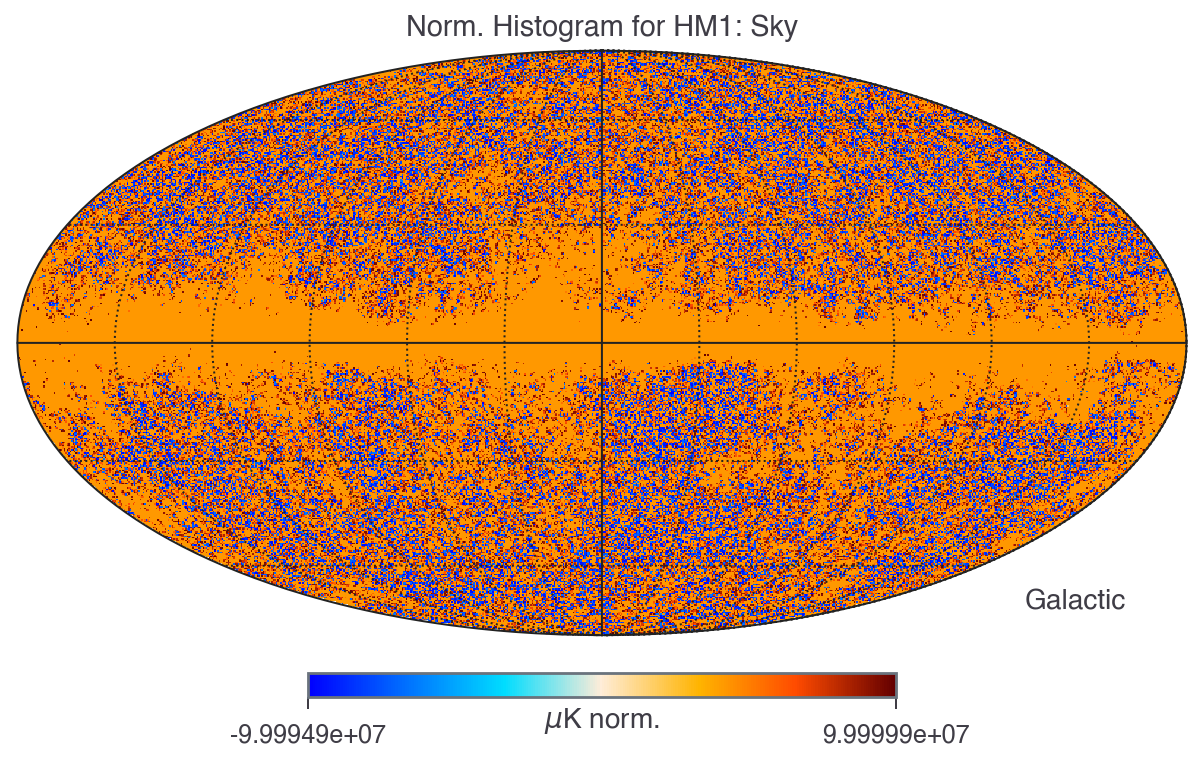

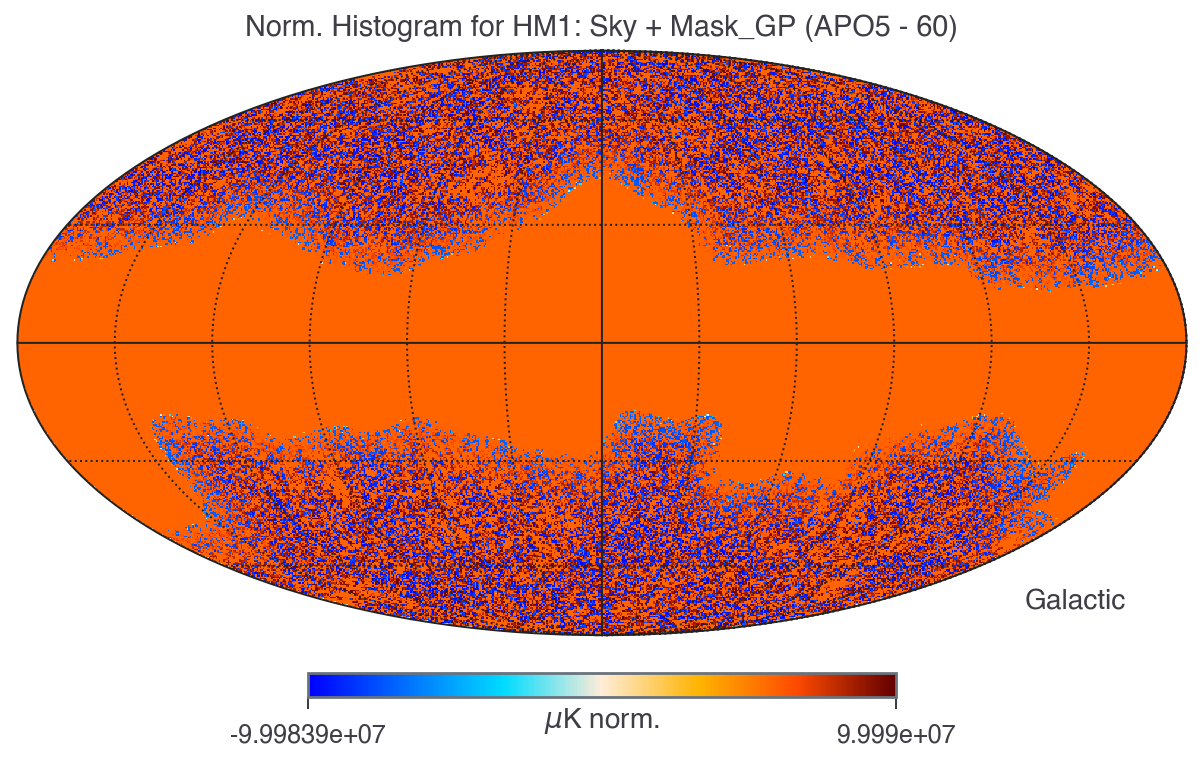

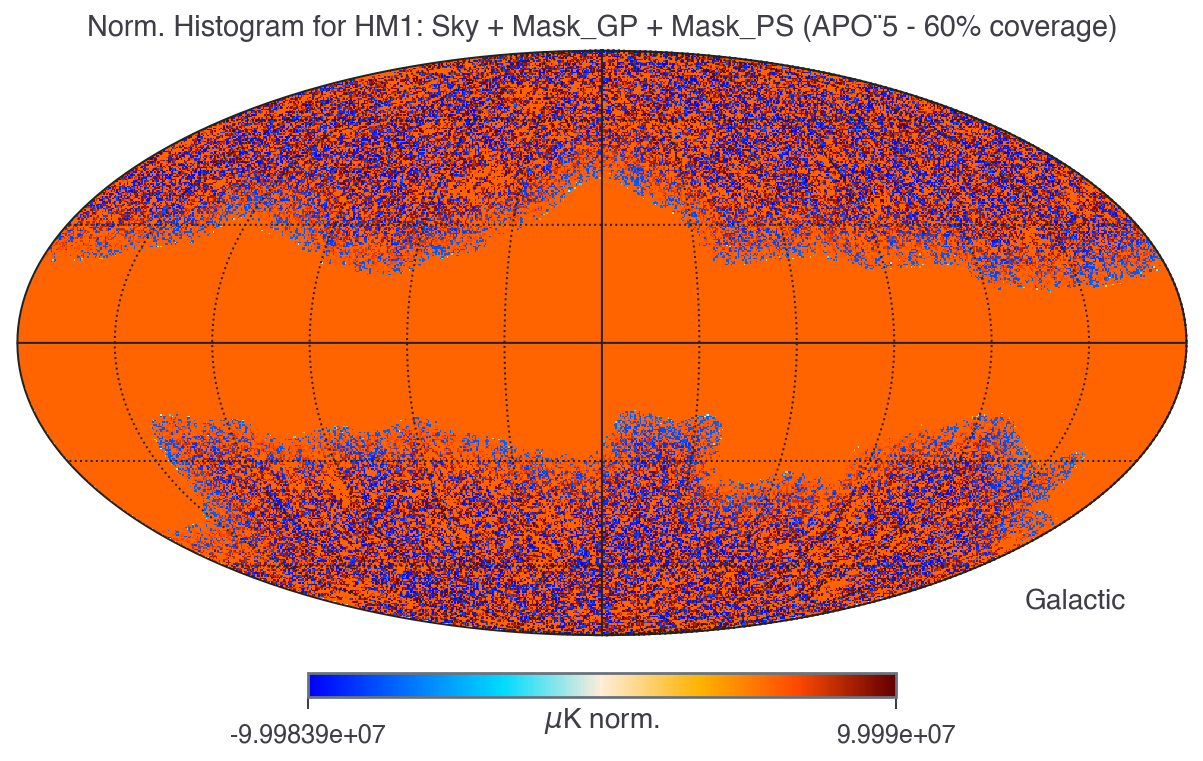

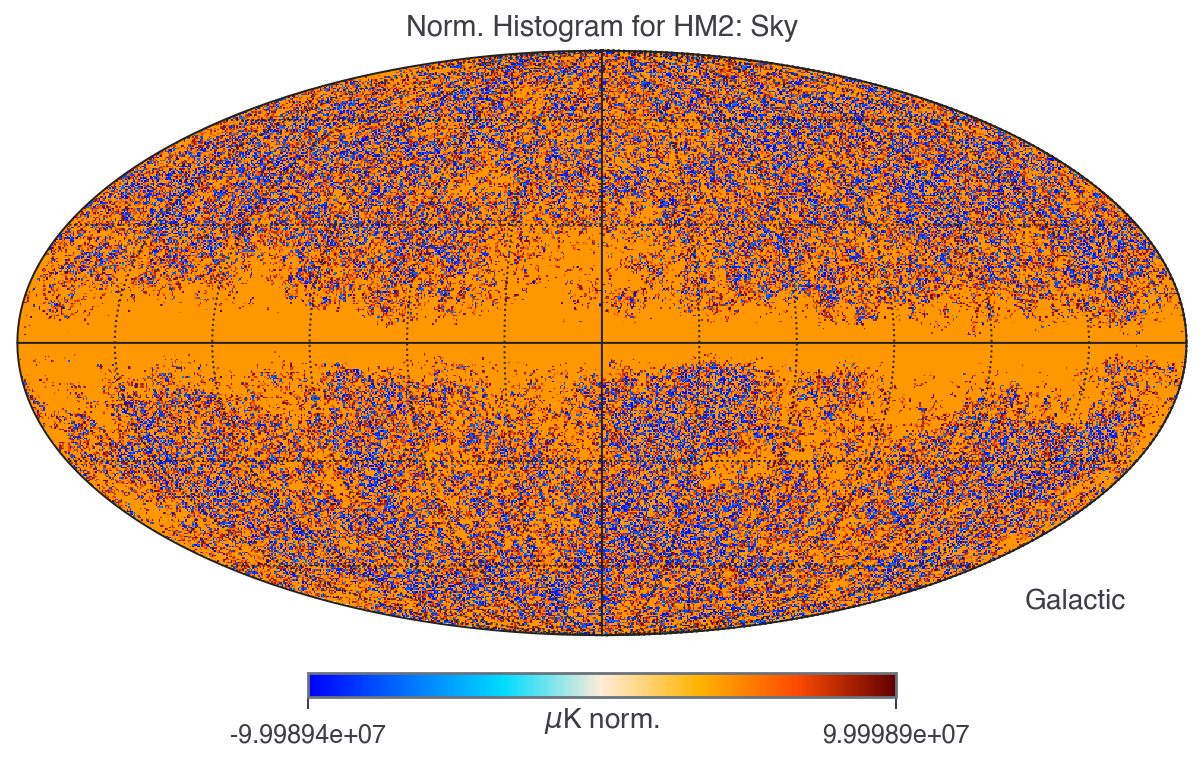

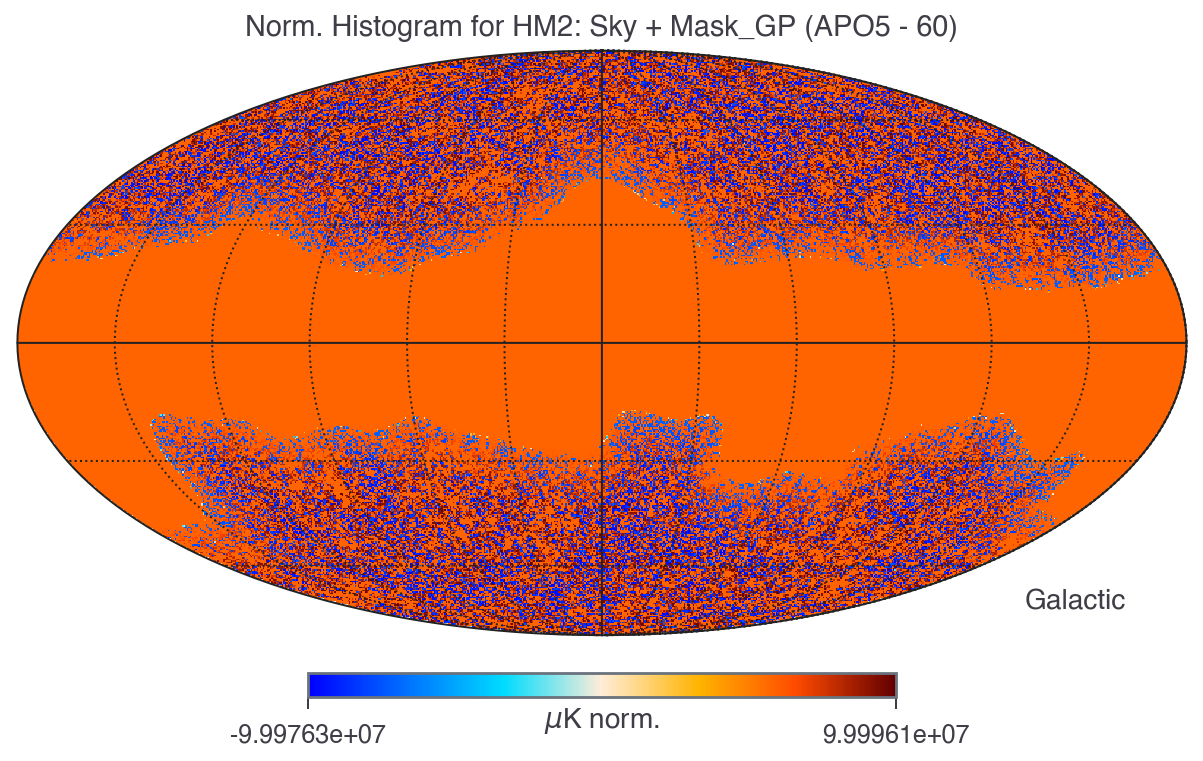

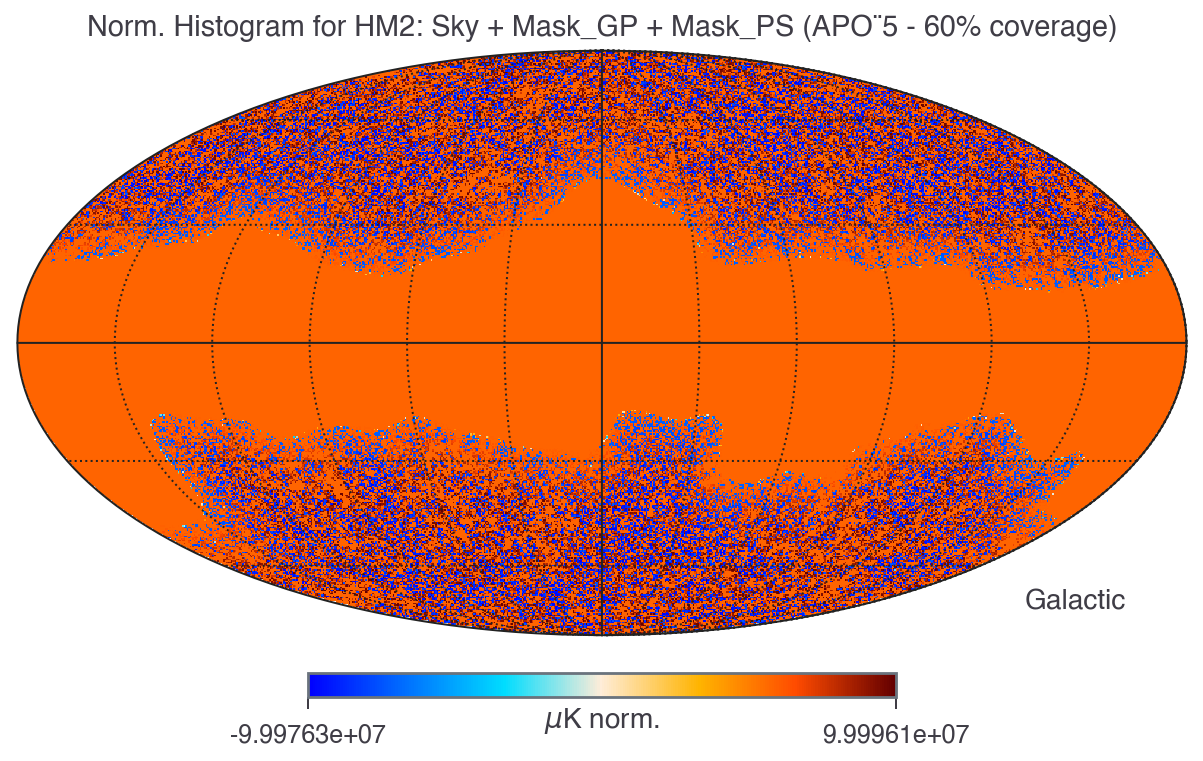

In [15]:
plot_array = [sky_hm1, sky_hm1*mask_gp, sky_hm1*mask_gp*mask_ps, 
              sky_hm2, sky_hm2*mask_gp, sky_hm2*mask_gp*mask_ps]

titles = ['Sky', f'Sky + Mask_GP (APO{APO} - {gal_cover})', f'Sky + Mask_GP + Mask_PS (APO¨{APO} - {gal_cover}% coverage)']

for i, arr in enumerate(plot_array):
    hp.mollview(arr*10**6, coord=["G"],  norm="hist",
                title=f"Norm. Histogram for HM{1 if i < 3 else 2}: {titles[i%3]}", 
                unit="$\mu$K norm.", cmap=cmap)
    
    hp.graticule()

## compute spherical harmoncis

In [ ]:
def find_spherical_harmonics(sky_i, gp_mask, ps_mask, 
                             lmax=4000, apply_mask=True):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    # rescale the sky map to mKelvin
    sky_i *= 10**6
    
    if apply_mask:
        x_masked = sky_i*gp_mask*ps_mask
    else:
        x_masked = sky_i
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, pol=False, lmax=lmax)             
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps)
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

## compute actual cross power spectrum

In [ ]:
def find_power_spectrum(alm_1, alm_2, bl_1=None, bl_2=None,
                        M_ll=1, f_l=1, n_l=0, NSIDE=2048,
                        which_return='both'):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    
    start = time.time()
    # compute pseudo power spectrum
    print(len(alm_1))
    D_l = hp.sphtfunc.alm2cl(alm_1, alm_2)
    
    if which_return=='pseudo':
        end = time.time()
        print(f'It took {end-start:.2f} s. to compute D_l')
        
        return D_l
    elif which_return=='actual' or which_return=='both':
        # now define all the instrument related biases
        bl_1, bl_2 = bl_1.astype(np.float), bl_2.astype(np.float)
        p_l = hp.sphtfunc.pixwin(NSIDE, lmax=len(bl_1)-1)
                
        # calculate actual power spectrum
        C_l = D_l/(p_l**2 * bl_1*bl_2)
        
        end = time.time()
        print(f'It took {end-start:.2f} s. to compute C_l')
        
        if which_return=='both':
            return (D_l, C_l)
        else:
            return C_l
        

D_l, C_l = find_power_spectrum(a_lm_1, a_lm_2, beam_hm1, beam_hm2, which_return='both')

def clean_power_spectrum(C_l, ind_low=20, ind_max=2000,
                         decimate=True, n_dec=2):
    '''
    document function once fully tested
    '''
    # define multipole array
    C_l = C_l[ind_low:ind_max]
    l = np.arange(len(C_l))
        
    Cl_planck = l*(l+1)*C_l/(2*np.pi)

    # decimate each array
    if decimate:
        n_dec = 2
        Cl_planck, l_planck = Cl_planck[::n_dec], l[::n_dec]
    
    return (l_planck, Cl_planck)

l_planck, Cl_planck = clean_power_spectrum(C_l)

## find a fit for the 1st peak of the cross power spectrum

In [ ]:
# find a fit using a polynomial approx
def poly_n(x,w):
    '''
    Document once function has been fully tested
    '''
    
    w = w[::-1]                                          # the last bit reverts array so lowest coefficient first
    X = np.array([x**i for i in range(len(w))])
    y = np.matmul(w,X)
    
    return y

def peak_finder(x,y):
    '''
    Finds the value of x for which y(x) is max (peaks)
    '''
    ind = np.where(y == np.max(y))
    x_peak = x[ind][0]
    
    return x_peak

def model_cl(l, a_0, a_2, l_p):
    return a_2*(l-l_p)**2 + a_0


# find an approximate fit for the first peak
n_l = 2536
l_a, l_b = 100, 320
ind_fit_a, ind_fit_b = np.where(l_planck == l_a)[0][0], np.where(l_planck == l_b)[0][0]

params_p1, cov_p1 = curve_fit(model_cl, l_planck[ind_fit_a:ind_fit_b], Cl_planck[ind_fit_a:ind_fit_b],
                             p0=[ 1.81914268e+03,-8.19192815e-02 ,2.11136936e+02]) 

l_fit = np.arange(n_l+1)
Cl_fit = model_cl(l_fit,*params_p1)

# The peak is now a fitting parameter, and the uncertainty is given in the fitting covariance matrix
lp_planck = params_p1[-1]
sigma_lp_planck = np.sqrt(np.diag(cov_p1)[-1])

fig, ax = plt.subplots(figsize=(13,9))

ax.plot(l_planck, Cl_planck, 'o', markersize=3, label='Planck Signal', color=colors[0])
ax.plot(l_fit[l_a:l_b], Cl_fit[l_a:l_b], '-',  color=colors[1], 
        label=f'Planck Fit: ' +r'$l_{peak}$ = '+f'{lp_planck:.2f}' + '$\pm$' + f'{sigma_lp_planck:.2f}') 
ax.axvline(lp_planck, color=colors[1])

ax.set_xlim([20,2000])

ax.set_xlabel('l')
ax.set_ylabel(r'$\frac{l(l+1)}{\pi} C_l$ [$(\mu K)^2$]')
plt.legend()
plt.show()

## compute boltzmann code for flat geometry

In [ ]:
# Set parameter from Planck
H_0 = 67.5

def boltzmann_cl(omega_bary, omega_cdm, omega_k, H_0=67.5):
    '''
    Document once fully tested
    '''
    # Initialize parameters of CAMB model
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H_0, ombh2=omega_bary, omch2=omega_cdm, omk=omega_k,  mnu=0.06,  tau=0.06)
    #pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)

    #calculate results for these parameters
    results = camb.get_results(pars)
    Cl_allpol = results.get_cmb_power_spectra(pars, CMB_unit='muK', spectra={'total'})['total']     # the C_l returned is already binned as l*(l+1)+C_l/(2pi)

    Cl_boltz = Cl_allpol[:,0]                                                          # we only need the TT/II polarization (i.e. the temperature)
    l_boltz = np.arange(Cl_boltz.shape[0])
    
    return l_boltz, Cl_boltz

# Set model params for fit
delta = 0.01                                                                           # spacing in omega_k between models
n_models = 4
guess = -0.03

omega_k = np.linspace(guess - (delta*n_models)/2, guess + (delta*n_models)/2, num=n_models)

boltzm_cosmo_params = {
    'omega_baryons': [0.022 for _ in range(n_models)],
    'omega_cdm': [0.122 for _ in range(n_models)],
    'omega_curv': omega_k
}

start_bc = time.time()
# compute power spectrum for each models and its associated l_peak
l_boltz, Cl_boltz, l_peaks_bc = [], [], []

print("Started computation of BC power spectrum for different cosmologies:")
print("="*70)
for i in range(n_models):
    omega_b_i, omega_cdm_i, omega_k_i = boltzm_cosmo_params['omega_baryons'][i], boltzm_cosmo_params['omega_cdm'][i], boltzm_cosmo_params['omega_curv'][i]
    l_i, Cl_i = boltzmann_cl(omega_b_i, omega_cdm_i, omega_k_i, H_0)
    l_boltz.append(l_i) 
    Cl_boltz.append(Cl_i)
    # find the peak
    l_peakbz_i = peak_finder(l_boltz[i], Cl_boltz[i])
    l_peaks_bc.append(l_peakbz_i)
    
    print(f"A model was succesfully constructed for: omega_bary = {omega_b_i:.2f}, omega_cdm = {omega_cdm_i:.2f}, omega_k = {omega_k_i:.3f} ")
    print("-"*100) , 
    
end_bc = time.time()
print(f'Computing the Boltzmann Code cross-power spectra took {end_bc-start_bc:.2f} s.')

## plotting cross power spectrums

In [ ]:
# Plotting the Planck spectra and model comparison

#norm_factor = Cl_boltz_0[l_peaks_bc[0]]/Cl_fit[np.where(Cl_fit == np.max(Cl_fit))[0][0]] 
norm_factor = np.mean(Cl_boltz_0[l_a:l_b]/Cl_fit[l_a:l_b])

fig, ax = plt.subplots(figsize=(13,9))
# plot the Planck data now
ax.plot(l_planck, norm_factor*Cl_planck, 'o', markersize=3, label='Planck Signal', color=colors[0])
ax.plot(l_fit[l_a:l_b], norm_factor*Cl_fit[l_a:l_b], '-', label=f'Planck Fit: ' +r'$l_{peak}$ = '+f'{l_peak_planck:.0f}', color=colors[4])
ax.axvline(l_peak_planck, color=colors[4])

# plotting 3 evenly spaced boltzman codes for reference
plot_bc = True
if plot_bc:
    for j in [0, -1]:
        omega_k_j = boltzm_cosmo_params['omega_curv'][j]
        ax.plot(l_boltz[j], Cl_boltz[j], '-', 
                label='Boltzmann Code: $\Omega_k=$ ' + f'{omega_k_j:.3f}: ' + r'$l_{peak}$ = '+f'{l_peaks_bc[j]:.0f}',
                color=colors[(2+j)%7])

        show_peak = False
        if show_peak:
            ax.axvline(l_peaks_bc[j], color=colors[(2+j)%10])
            #ax.text(l_peakbz_i+6, 400 + 400*i, r'$l_{peak}$ = '+f'{l_peakbz_i:.0f}', color=colors[3+i])


#ax.set_yscale('log')
ax.set_xlim([20,2000])

ax.set_title(f'Planck CMB Anisotropy at {FREQ} GHZ, APO{APO} and ' + '$f_{sky} = $'+f'{gal_cover}%')
ax.set_xlabel('l')
ax.set_ylabel(r'$\frac{l(l+1)}{\pi} C_l$ [$(\mu K)^2$]')

plt.legend(loc=0)

save_fig = False
if save_fig:
    cps_title = f'plots/CMB_CrossPowerSpectrum_w/BC_{FREQ}x{FREQ}__APO{APO}__{gal_cover}%_{today}.png'
    try:
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(cps_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
plt.show()

### Estimating $\Omega_k$ for the CMB signal

In [ ]:
l_peak_planck = lp_planck

# Find a fit for omega_k vs. l_peak for the Boltzmann code
params_p2, cov_p2 = np.polyfit(l_peaks_bc, omega_k, deg=1, cov=True)            # highest order coefficients are returned first
a1_lin, a0_lin = params_p2
sigma_a1, sigma_a0 = np.sqrt(np.diag(cov_p2))

l_peak_fit = np.linspace(l_peaks_bc[0]-1,l_peaks_bc[-1]+1, num=5000)
om_k_fit = poly_n(l_peak_fit,params_p2)

# find omega_k estiamte for planck data
om_k_planck = l_peak_planck*a1_lin + a0_lin

# propagate uncertainty to find sigma_omegak
def sigma_omk(l, a0, a1, 
              s_l, s_a0, s_a1):
    
    var = (a1*s_l)**2 + s_a0**2 + (l*s_a1)**2
    return np.sqrt(var)

sigma_omega_k = sigma_omk(lp_planck, a0_lin, a1_lin, sigma_lp_planck, sigma_a0, sigma_a1)   # sigma_a0, sigma_a1 = 0 as otherwise uncertainty becomes too great

# Finally plot the curvature density fit
fig, ax = plt.subplots(figsize=(13,9))
ax.plot(l_peaks_bc, omega_k, 'o', color=colors[0])
ax.plot(l_peak_fit, om_k_fit, color=colors[1],
        label='Best Fit: $\Omega_k(l_{peak})$ = ' + f'{a0_lin:.2f} + {a1_lin:.3f}'+'$l_{peak}$')
ax.axhline(om_k_planck, color=colors[2],
           label='Planck estimate: $\Omega_k$ = ' + f'{om_k_planck:.3f}' +'$\pm$' + f'{sigma_omega_k:.3f}')

ax.set_title(f'Planck Curvature Density ($\Omega_k$) Estimate')
ax.set_xlabel('$l_{peak}$')
ax.set_ylabel(r'$\Omega_k$')
plt.legend(loc=0)

save_fig = True
if save_fig:
    k_title = f'plots/CMB_DensityCurvature_{FREQ}x{FREQ}_{today}.png'
    try:
        plt.savefig(k_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir('plots')
        plt.savefig(k_title, format='png', dpi=200, pad_inches=0.1, bbox_inches='tight')

plt.show()